In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.calibration import calibration_curve

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import (
    FEATURE_CACHE_PATH,
    ACTIVE_MODEL_VERSION,
    ACTIVE_FEATURES,
    get_display_name,
    get_ale_filename,
    FEATURE_BOUNDS,
)
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling import CreditRiskLogit, compute_ece, compute_ale_for_feature, compute_ale_binary
from credit_risk_xai.modeling.train import DEFAULT_PARAMS, run_lightgbm_training

FIGURES_DIR = PROJ_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

print(f"Model version: {ACTIVE_MODEL_VERSION} ({len(ACTIVE_FEATURES)} features)")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model version: v2 (22 features)


# Chapter 1: Global Model Understanding


In [2]:
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[
    (df["ser_aktiv"] == 1) & 
    (df["sme_category"].isin(["Small", "Medium"])) & 
    (df["knc_kncfall"] == 1) &
    (df["bransch_borsbransch_konv"] != "40.0")
]

X, y = prepare_modeling_data(df)
print(f"Data: {len(X):,} samples, {X.shape[1]} features, imbalance {(y==0).sum()/(y==1).sum():.0f}:1")

Data: 304,149 samples, 22 features, imbalance 56:1


In [3]:
results = run_lightgbm_training(X=X, y=y, use_wandb=False)

[50]	training's binary_logloss: 0.0616846	valid_1's binary_logloss: 0.0673924
[100]	training's binary_logloss: 0.0583939	valid_1's binary_logloss: 0.066455
[150]	training's binary_logloss: 0.0561879	valid_1's binary_logloss: 0.0661763
[200]	training's binary_logloss: 0.0543006	valid_1's binary_logloss: 0.0660327


In [4]:
model = results["model"]
X_train, X_val = results["X_train"], results["X_val"]
y_train, y_val = results["y_train"], results["y_val"]
y_pred_proba = results["y_val_proba"]

print(f"LightGBM: AUC={roc_auc_score(y_val, y_pred_proba):.4f}, LogLoss={log_loss(y_val, y_pred_proba):.4f}")

LightGBM: AUC=0.8972, LogLoss=0.0660


# Phase 1: Foundation & Baseline Comparison

Following the comprehensive XAI thesis plan, we'll establish baselines and infrastructure for all subsequent analyses.

In [5]:
logit_model = CreditRiskLogit()
logit_model.fit(X_train, y_train)

logit_val_proba = logit_model.predict_proba(X_val)[:, 1]
X_train_processed = logit_model.transform(X_train)
X_val_processed = logit_model.transform(X_val)

print(f"Logit: AUC={roc_auc_score(y_val, logit_val_proba):.4f}, LogLoss={log_loss(y_val, logit_val_proba):.4f}")

Logit: AUC=0.8685, LogLoss=0.0712


In [6]:
from sklearn.metrics import brier_score_loss

metrics = {
    'Model': ['LightGBM', 'Logistic', 'Δ'],
    'AUC': [roc_auc_score(y_val, y_pred_proba), roc_auc_score(y_val, logit_val_proba), 0],
    'Log Loss': [log_loss(y_val, y_pred_proba), log_loss(y_val, logit_val_proba), 0],
    'Brier': [brier_score_loss(y_val, y_pred_proba), brier_score_loss(y_val, logit_val_proba), 0],
    'ECE': [compute_ece(y_val, y_pred_proba), compute_ece(y_val, logit_val_proba), 0],
}
for col in ['AUC', 'Log Loss', 'Brier', 'ECE']:
    metrics[col][2] = metrics[col][0] - metrics[col][1]

pd.DataFrame(metrics)

,Model,AUC,Log Loss,Brier,ECE
0,LightGBM,0.897160,0.066015,0.015851,0.003224
1,Logistic,0.868475,0.071165,0.016483,0.004103
2,Δ,0.028686,-0.005150,-0.000631,-0.000879


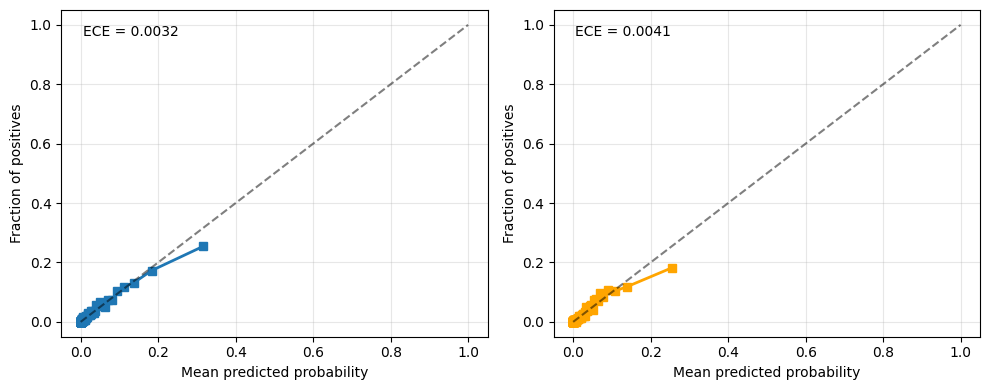

In [7]:
lgbm_ece = compute_ece(y_val, y_pred_proba)
logit_ece = compute_ece(y_val, logit_val_proba)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

fraction_pos_lgbm, mean_pred_lgbm = calibration_curve(y_val, y_pred_proba, n_bins=100, strategy='quantile')
axes[0].plot(mean_pred_lgbm, fraction_pos_lgbm, 's-', label='LightGBM', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('Mean predicted probability')
axes[0].set_ylabel('Fraction of positives')
axes[0].text(0.05, 0.92, f'ECE = {lgbm_ece:.4f}', transform=axes[0].transAxes)
axes[0].grid(alpha=0.3)

fraction_pos_logit, mean_pred_logit = calibration_curve(y_val, logit_val_proba, n_bins=100, strategy='quantile')
axes[1].plot(mean_pred_logit, fraction_pos_logit, 's-', label='Logistic', linewidth=2, color='orange')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('Mean predicted probability')
axes[1].set_ylabel('Fraction of positives')
axes[1].text(0.05, 0.92, f'ECE = {logit_ece:.4f}', transform=axes[1].transAxes)
axes[1].grid(alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'ece_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [8]:
explainer_lgbm = shap.TreeExplainer(model)
shap_values_lgbm = explainer_lgbm.shap_values(X_val)
if isinstance(shap_values_lgbm, list):
    shap_values_lgbm = shap_values_lgbm[1]

explainer_logit = shap.LinearExplainer(logit_model, X_train_processed, feature_perturbation="interventional")
shap_values_logit = explainer_logit.shap_values(X_val_processed)

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [9]:
import pickle

results_dir = PROJ_ROOT / "results" / "xai_exploration"
results_dir.mkdir(parents=True, exist_ok=True)
cache_file = results_dir / "shap_cache.pkl"

shap_cache = {
    'shap_values_lgbm': np.asarray(shap_values_lgbm, dtype=np.float64),
    'shap_values_logit': np.asarray(shap_values_logit, dtype=np.float64),
    'explainer_lgbm': explainer_lgbm,
    'X_val': X_val,
    'y_val': y_val,
    'y_pred_proba_lgbm': np.asarray(y_pred_proba, dtype=np.float64),
    'y_pred_proba_logit': np.asarray(logit_val_proba, dtype=np.float64),
    'feature_names': X_val.columns.tolist()
}

with open(cache_file, 'wb') as f:
    pickle.dump(shap_cache, f)

# Phase 2: Global Model Understanding (Chapter 1)

In this section, we analyze what the models learned and how they differ from traditional credit theory.

In [10]:
feature_names = X_val.columns.tolist()

lgbm_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'lgbm_shap': np.abs(shap_values_lgbm).mean(axis=0)
})

logit_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'logit_shap': np.abs(shap_values_logit).mean(axis=0)
})

lgbm_importance_gain = pd.DataFrame({
    'feature': feature_names,
    'lgbm_gain': model.feature_importances_
})

logit_coefficients = pd.DataFrame({
    'feature': feature_names,
    'logit_coef': np.abs(logit_model.coef_[0])
})

importance_comparison = (
    lgbm_importance_shap
    .merge(logit_importance_shap, on='feature')
    .merge(lgbm_importance_gain, on='feature')
    .merge(logit_coefficients, on='feature')
)

for col in ['lgbm_shap', 'logit_shap', 'lgbm_gain', 'logit_coef']:
    importance_comparison[f'{col}_norm'] = 100 * importance_comparison[col] / importance_comparison[col].max()

importance_comparison['lgbm_shap_rank'] = importance_comparison['lgbm_shap'].rank(ascending=False)
importance_comparison['logit_shap_rank'] = importance_comparison['logit_shap'].rank(ascending=False)

important_features = importance_comparison.nlargest(20, 'lgbm_shap')[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 'lgbm_shap_norm', 'logit_shap_norm', 'lgbm_gain_norm', 'logit_coef_norm']
]
important_features['rank_diff'] = important_features['logit_shap_rank'] - important_features['lgbm_shap_rank']
important_features['feature'] = important_features['feature'].apply(get_display_name)
important_features

,feature,lgbm_shap_rank,logit_shap_rank,lgbm_shap_norm,logit_shap_norm,lgbm_gain_norm,logit_coef_norm,rank_diff
15,Dividend Payer,1.0,10.0,100.000000,7.395055,8.478803,0.788523,9.0
13,Cash Ratio,2.0,13.0,82.654309,6.180856,40.773067,0.722053,11.0
1,Industry (SNI),3.0,14.0,54.784529,5.856108,100.000000,0.682043,11.0
3,Debt Ratio,4.0,22.0,52.289730,0.359987,31.296758,0.038915,18.0
0,Company Age,5.0,4.0,48.998783,25.997672,35.785536,2.966151,-1.0
9,Log Total Assets,6.0,20.0,42.191473,3.511432,47.007481,0.396216,14.0
5,Return on Equity,7.0,15.0,38.136228,5.619677,37.281796,0.610254,8.0
2,Total Asset Turnover,8.0,18.0,36.732560,4.167320,44.513716,0.450289,10.0
12,Interest Coverage,9.0,1.0,30.282678,100.000000,51.371571,9.742844,-8.0
18,Revenue CAGR (3Y),10.0,12.0,29.261536,6.976595,43.890274,0.832367,2.0


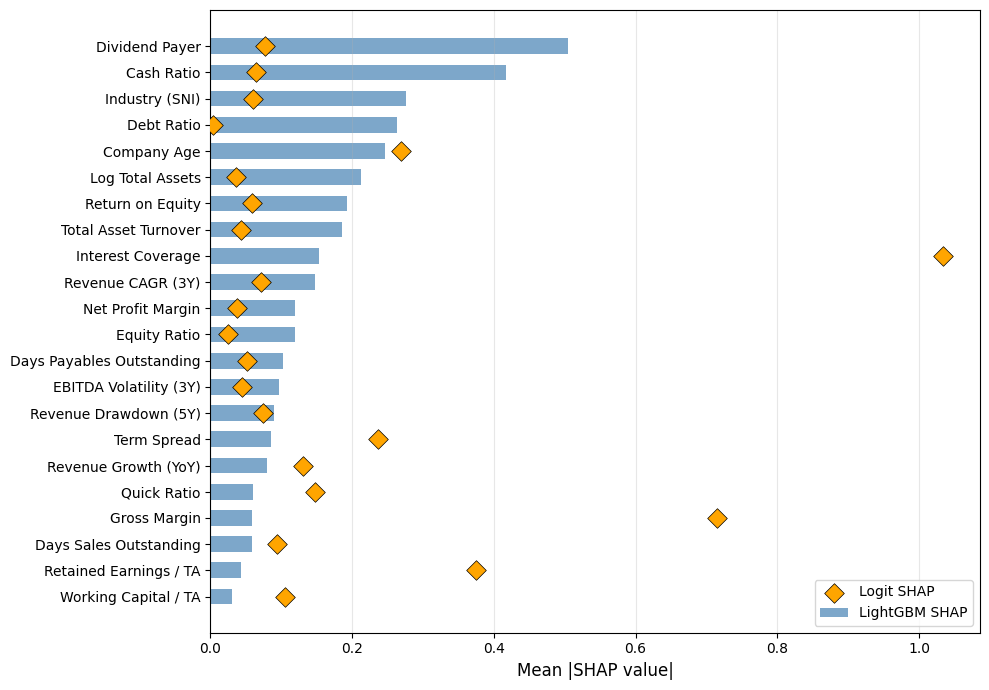

In [11]:
## Feature Importance Comparison Visualization

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Get top 15 features by LightGBM SHAP
top_lgbm_features = importance_comparison.copy()

# Sort by lgbm_shap for plotting (ascending for horizontal bar chart)
top_lgbm_features = top_lgbm_features.sort_values('lgbm_shap')

y_pos = np.arange(len(top_lgbm_features))

# Plot LightGBM SHAP as bars
ax.barh(y_pos, top_lgbm_features['lgbm_shap'], 
        color='steelblue', alpha=0.7, label='LightGBM SHAP', height=0.6)

# Overlay Logit SHAP as markers
ax.scatter(top_lgbm_features['logit_shap'], y_pos, 
           color='orange', s=100, marker='D', 
           label='Logit SHAP', zorder=3, edgecolors='black', linewidths=0.5)

# Formatting
ax.set_xlabel('Mean |SHAP value|', fontsize=12)

# Map feature names to display names for y-axis labels
display_labels = [get_display_name(f) for f in top_lgbm_features['feature']]

ax.set_yticks(y_pos)
ax.set_yticklabels(display_labels, fontsize=10)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3)

# Add vertical line at x=0 for reference
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'shap_importance_comparison.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.show()

In [12]:
top_features = importance_comparison['feature'].tolist()

# Filter out categorical features first, then split into continuous vs binary
non_categorical = [f for f in top_features if f in X_val.columns and X_val[f].dtype.name != 'category']
continuous_features = [f for f in non_categorical if FEATURE_BOUNDS.get(f) is not None]
binary_features = [f for f in non_categorical if FEATURE_BOUNDS.get(f) is None]

def predict_lgbm(X):
    return model.predict_proba(X)

def predict_logit(X):
    return logit_model.predict_proba(X)

ale_results = {}

for i, feature in enumerate(binary_features, 1):
    print(f"[B{i}/{len(binary_features)}] {feature}...")
    ale_results[feature] = {'is_binary': True}
    
    grid_lgbm, ale_lgbm, bounds_lgbm = compute_ale_binary(predict_lgbm, X_val, feature)
    ale_results[feature]['lgbm'] = {'grid': grid_lgbm, 'ale': ale_lgbm, 'bounds': bounds_lgbm}
    
    grid_logit, ale_logit, bounds_logit = compute_ale_binary(predict_logit, X_val, feature)
    ale_results[feature]['logit'] = {'grid': grid_logit, 'ale': ale_logit, 'bounds': bounds_logit}

for i, feature in enumerate(continuous_features, 1):
    print(f"[{i}/{len(continuous_features)}] {feature}...")
    bounds = FEATURE_BOUNDS.get(feature)
    ale_results[feature] = {}
    
    grid_lgbm, ale_lgbm, bounds_lgbm = compute_ale_for_feature(predict_lgbm, X_val, feature, feature_bounds=bounds)
    ale_results[feature]['lgbm'] = {'grid': grid_lgbm, 'ale': ale_lgbm, 'bounds': bounds_lgbm}
    
    grid_logit, ale_logit, bounds_logit = compute_ale_for_feature(predict_logit, X_val, feature, feature_bounds=bounds)
    ale_results[feature]['logit'] = {'grid': grid_logit, 'ale': ale_logit, 'bounds': bounds_logit}

[B1/1] dividend_yield...
[1/20] company_age...
[2/20] ny_kapomsh...
[3/20] ny_skuldgrd...
[4/20] ny_solid...
[5/20] ny_avkegkap...
[6/20] ny_kasslikv...
[7/20] ny_nettomarg...
[8/20] ny_omsf...
[9/20] log_total_assets...
[10/20] working_capital_ta...
[11/20] retained_earnings_ta...
[12/20] interest_coverage...
[13/20] ratio_cash_liquidity...
[14/20] gross_margin...
[15/20] dso_days...
[16/20] dpo_days...
[17/20] revenue_cagr_3y...
[18/20] revenue_drawdown_5y...
[19/20] ebitda_volatility...
[20/20] term_spread...


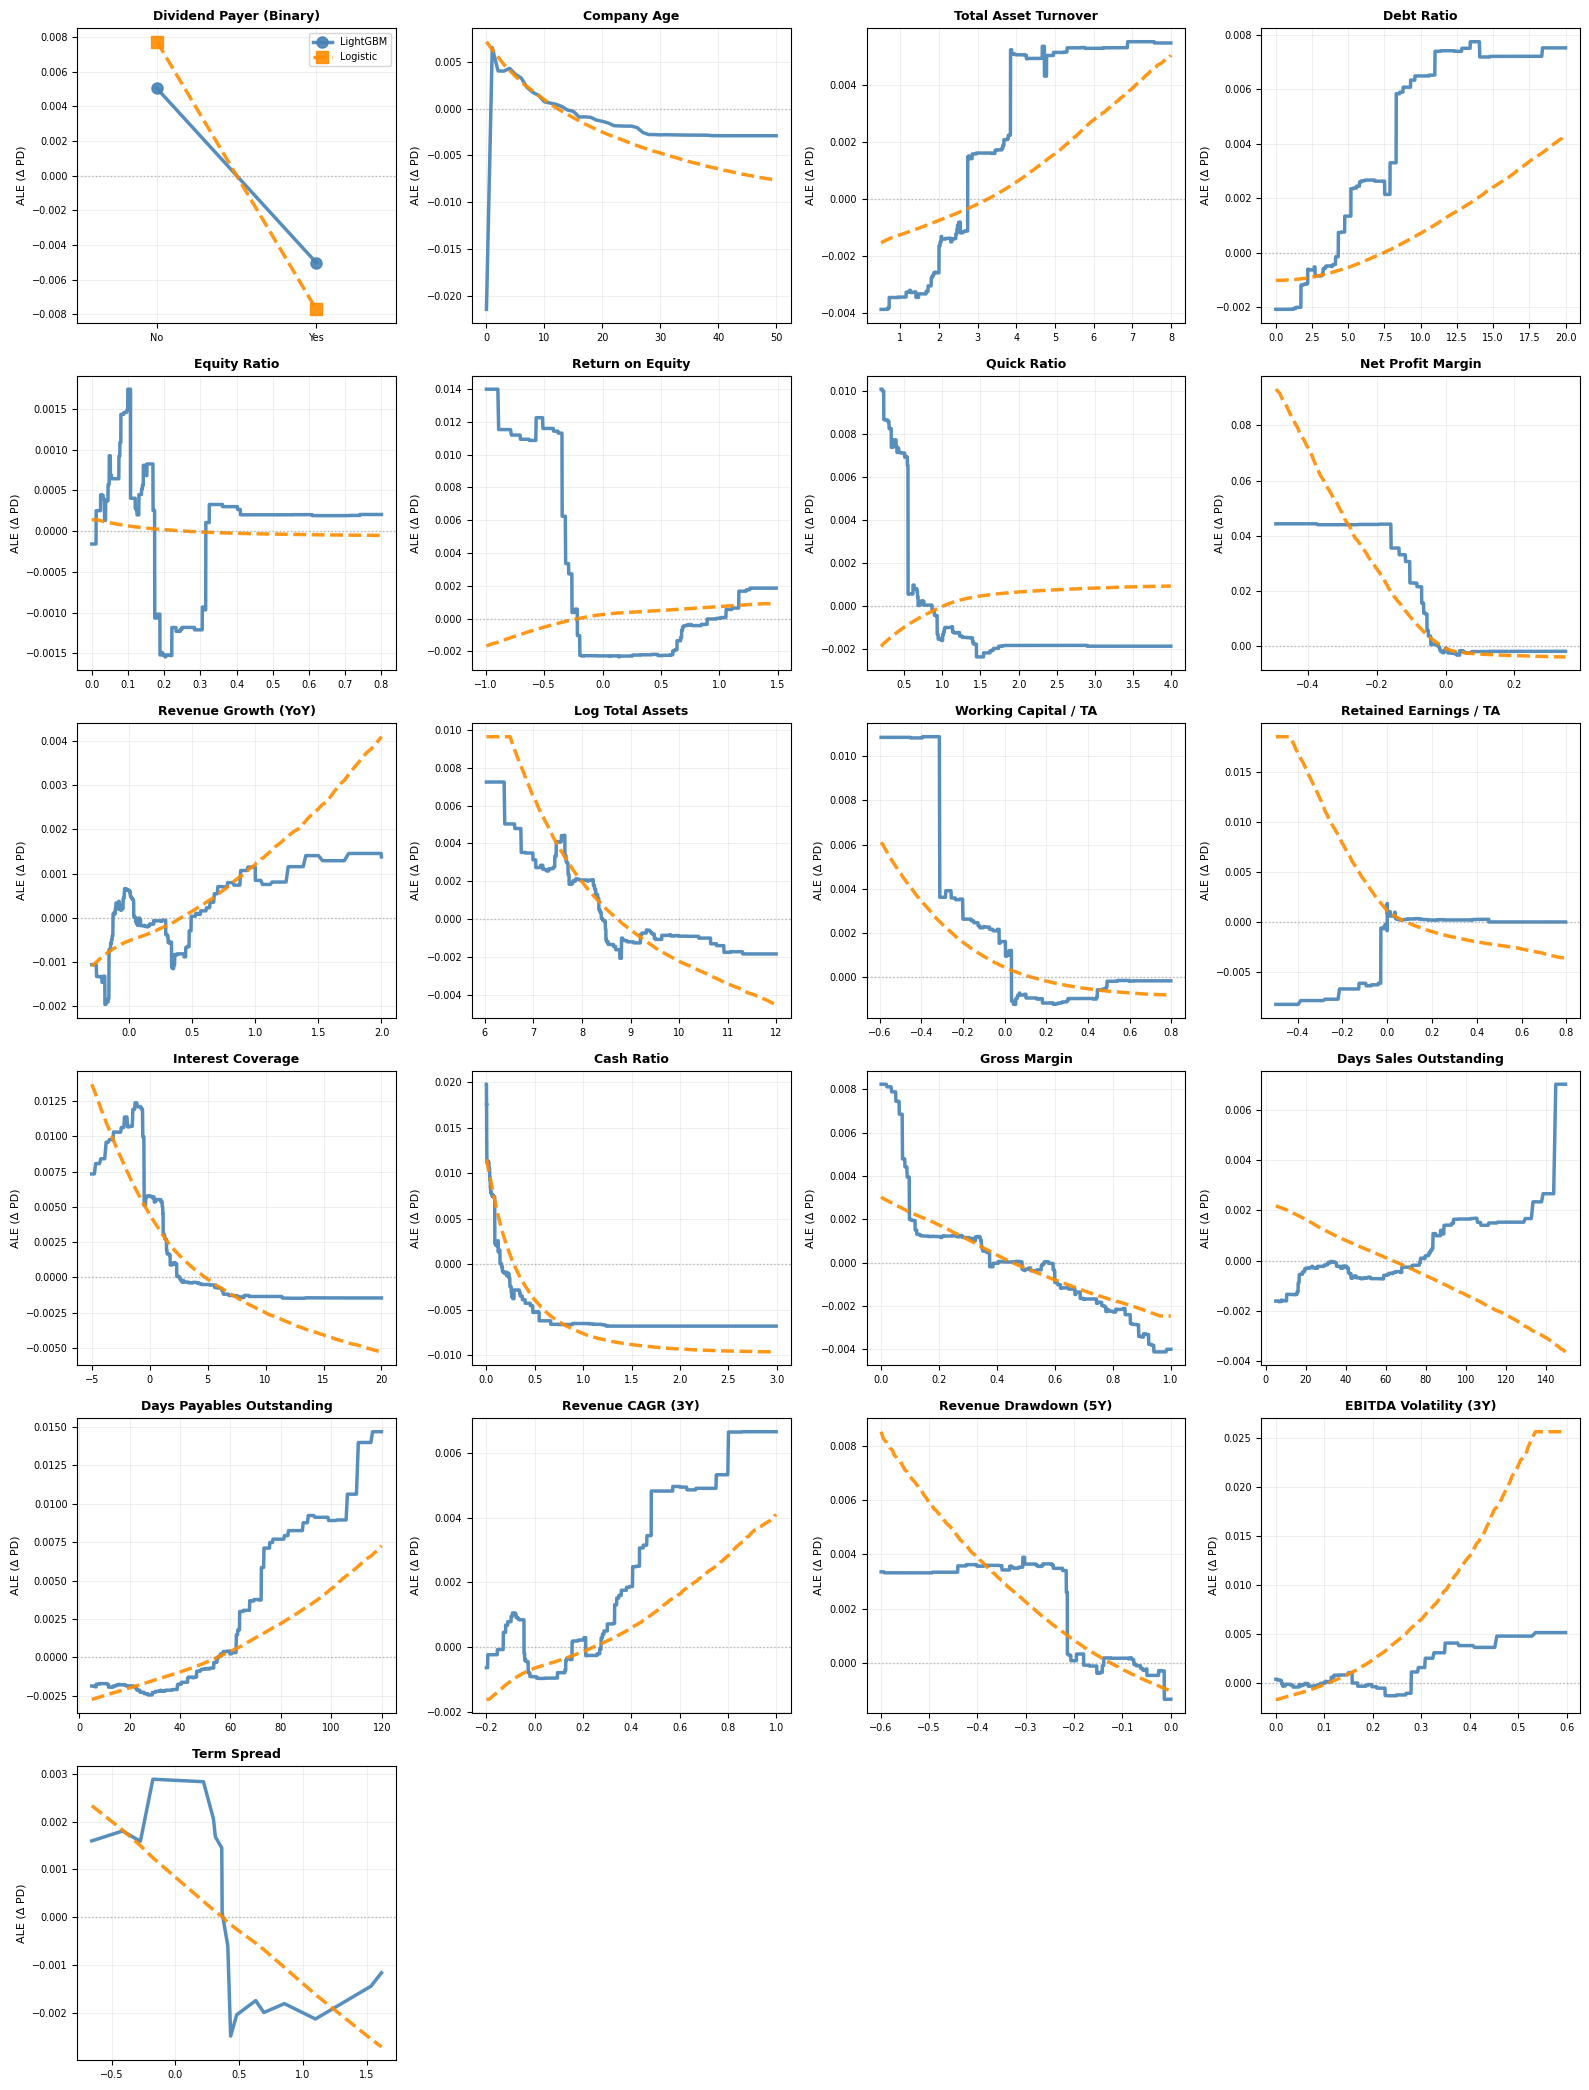

In [13]:
n_plots = len(ale_results)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
axes = axes.flatten()

for idx, (feature, data) in enumerate(ale_results.items()):
    ax = axes[idx]
    display_name = get_display_name(feature)
    
    has_lgbm = 'lgbm' in data and len(data['lgbm']['grid']) > 0
    has_logit = 'logit' in data and len(data['logit']['grid']) > 0
    
    if not has_lgbm and not has_logit:
        ax.text(0.5, 0.5, f"{display_name}\n(no data)", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(display_name, fontsize=9, fontweight='bold')
        continue
    
    is_binary = data.get('is_binary', False)
    
    if has_lgbm:
        ax.plot(data['lgbm']['grid'], data['lgbm']['ale'], 
                label='LightGBM', linewidth=2.5, color='steelblue', alpha=0.9,
                marker='o' if is_binary else None, markersize=8)
    
    if has_logit:
        ax.plot(data['logit']['grid'], data['logit']['ale'], 
                label='Logistic', linewidth=2.5, color='darkorange', alpha=0.9, 
                linestyle='--', marker='s' if is_binary else None, markersize=8)
    
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    if not is_binary:
        all_x = []
        if has_lgbm:
            all_x.extend(data['lgbm']['grid'])
        if has_logit:
            all_x.extend(data['logit']['grid'])
        if len(all_x) > 0:
            all_x = np.array(all_x)
            x_padding = (all_x.max() - all_x.min()) * 0.05
            ax.set_xlim(all_x.min() - x_padding, all_x.max() + x_padding)
    
    bounds = data['lgbm']['bounds'] if has_lgbm else data['logit']['bounds']
    
    if is_binary:
        ax.set_title(f"{display_name} (Binary)", fontsize=9, fontweight='bold')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['No', 'Yes'])
        ax.set_xlim(-0.5, 1.5)
    else:
        ax.set_title(display_name, fontsize=9, fontweight='bold')
    
    ax.set_ylabel('ALE (Δ PD)', fontsize=8)
    ax.tick_params(labelsize=7)
    ax.grid(alpha=0.2)
    
    if idx == 0:
        ax.legend(loc='best', fontsize=7)

for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'ale_full.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

In [14]:
SELECTED_ALE_FEATURES = [
    'ny_avkegkap', 'company_age', 'ratio_cash_liquidity', 'ny_rs',
    'dpo_days', 'ny_solid_yoy_diff', 'ny_nettomarg',
]

for feature in SELECTED_ALE_FEATURES:
    if feature not in ale_results:
        continue
    
    data = ale_results[feature]
    display_name = get_display_name(feature)
    filename = get_ale_filename(feature)
    
    has_lgbm = 'lgbm' in data and len(data['lgbm']['grid']) > 0
    has_logit = 'logit' in data and len(data['logit']['grid']) > 0
    
    if not has_lgbm and not has_logit:
        continue
    
    is_binary = data.get('is_binary', False)
    fig, ax = plt.subplots(figsize=(6, 4))
    
    if has_lgbm:
        ax.plot(data['lgbm']['grid'], data['lgbm']['ale'], 
                label='LightGBM', linewidth=2.5, color='steelblue',
                marker='o' if is_binary else None, markersize=8)
    
    if has_logit:
        ax.plot(data['logit']['grid'], data['logit']['ale'], 
                label='Logistic', linewidth=2.5, color='orange',
                marker='s' if is_binary else None, markersize=8)
    
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax.set_xlabel(display_name, fontsize=11)
    ax.set_ylabel('ALE (Δ Default Probability)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / filename, format='pdf', bbox_inches='tight')
    plt.close()

In [15]:
shap_values_lgbm_plot = np.asarray(shap_values_lgbm, dtype=np.float64)
shap_values_logit_plot = np.asarray(shap_values_logit, dtype=np.float64)

X_val_display = X_val.rename(columns=lambda c: get_display_name(c))
X_val_processed_display = X_val_processed.rename(columns=lambda c: get_display_name(c))

# LightGBM SHAP Summary
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(shap_values_lgbm_plot, X_val_display, max_display=20, show=False)
fig.savefig(FIGURES_DIR / 'shap_beeswarm_lgbm.pdf', format='pdf', bbox_inches='tight')
plt.close()

# Logistic SHAP Summary
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(shap_values_logit_plot, X_val_processed_display, max_display=20, show=False)
fig.savefig(FIGURES_DIR / 'shap_beeswarm_logit.pdf', format='pdf', bbox_inches='tight')
plt.close()

In [16]:
np.random.seed(42)
sample_size = min(10000, len(X_val))
sample_idx = np.random.choice(len(X_val), size=sample_size, replace=False)
X_val_sample = X_val.iloc[sample_idx]

shap_interaction_values = explainer_lgbm.shap_interaction_values(X_val_sample)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

interaction_matrix = np.abs(shap_interaction_values).mean(axis=0)
np.fill_diagonal(interaction_matrix, 0)

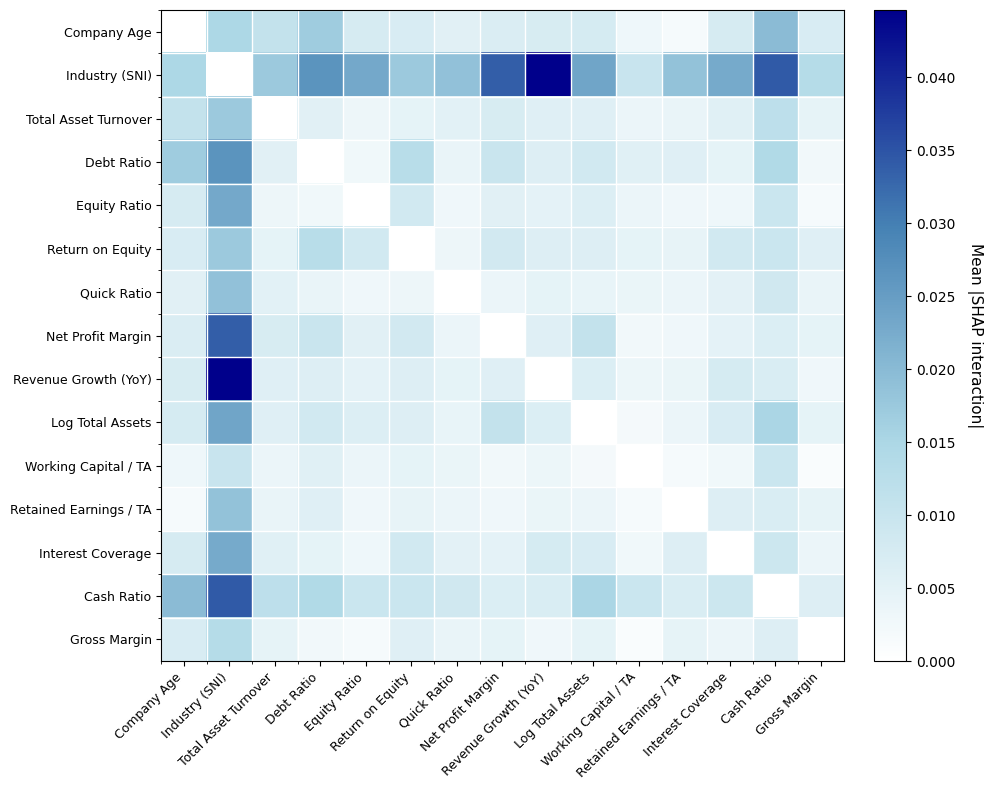

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

top_15_features = importance_comparison.head(15)['feature'].tolist()
top_15_indices = [X_val.columns.get_loc(f) for f in top_15_features]
top_15_display_names = [get_display_name(f) for f in top_15_features]
interaction_submatrix = interaction_matrix[np.ix_(top_15_indices, top_15_indices)]

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('interaction', ['white', 'lightblue', 'steelblue', 'darkblue'])

im = ax.imshow(interaction_submatrix, cmap=cmap, aspect='auto')

ax.set_xticks(np.arange(len(top_15_features)))
ax.set_yticks(np.arange(len(top_15_features)))
ax.set_xticklabels(top_15_display_names, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(top_15_display_names, fontsize=9)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Mean |SHAP interaction|', rotation=270, labelpad=20, fontsize=11)

ax.set_xticks(np.arange(len(top_15_features)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(top_15_features)) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=1)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'shap_interaction_heatmap.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

In [18]:
feature_names = X_val.columns.tolist()

main_effects_per_sample = np.array([
    shap_interaction_values[i].diagonal() for i in range(len(shap_interaction_values))
])
total_main_effect = np.abs(main_effects_per_sample).sum(axis=1)

interaction_effects_per_sample = np.array([
    np.abs(shap_interaction_values[i]).sum() - np.abs(shap_interaction_values[i].diagonal()).sum()
    for i in range(len(shap_interaction_values))
]) / 2

total_effect = total_main_effect + interaction_effects_per_sample
interaction_ratio_per_sample = interaction_effects_per_sample / total_effect

sample_preds = model.predict_proba(X_val_sample)[:, 1]
risk_df = pd.DataFrame({
    'sample_idx': sample_idx,
    'predicted_prob': sample_preds,
    'main_effect': total_main_effect,
    'interaction_effect': interaction_effects_per_sample,
    'interaction_ratio': interaction_ratio_per_sample
})
risk_df['risk_decile'] = pd.qcut(risk_df['predicted_prob'], 10, labels=[f'D{i+1}' for i in range(10)])

y_pred_sample = sample_preds

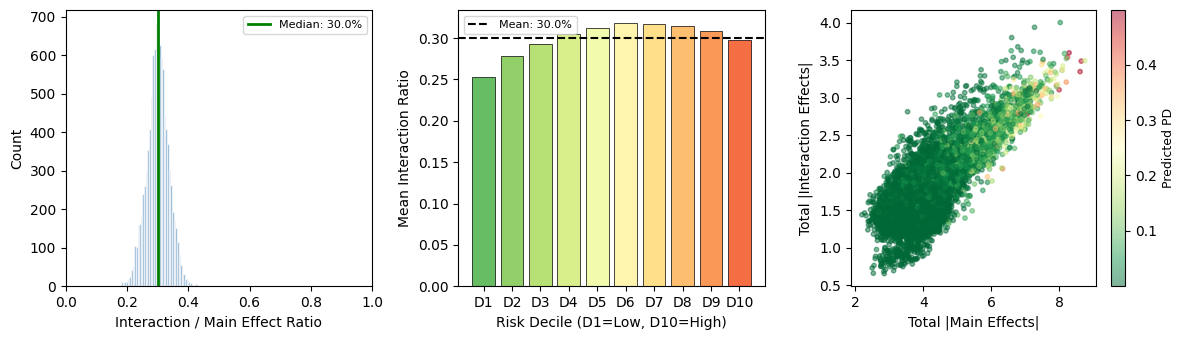

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

ax1 = axes[0]
ax1.hist(interaction_ratio_per_sample, bins=50, color='steelblue', alpha=0.7, edgecolor='white')
ax1.axvline(x=np.median(interaction_ratio_per_sample), color='green', linestyle='-', 
            linewidth=2, label=f'Median: {np.median(interaction_ratio_per_sample):.1%}')
ax1.set_xlabel('Interaction / Main Effect Ratio', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.legend(fontsize=8)
ax1.set_xlim(0, 1)

ax2 = axes[1]
decile_means = [risk_df[risk_df['risk_decile'] == f'D{i+1}']['interaction_ratio'].mean() 
                for i in range(10)]
decile_labels = [f'D{i+1}' for i in range(10)]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 10))
ax2.bar(decile_labels, decile_means, color=colors, edgecolor='black', linewidth=0.5)
ax2.axhline(y=np.mean(interaction_ratio_per_sample), color='black', linestyle='--', 
            linewidth=1.5, label=f'Mean: {np.mean(interaction_ratio_per_sample):.1%}')
ax2.set_xlabel('Risk Decile (D1=Low, D10=High)', fontsize=10)
ax2.set_ylabel('Mean Interaction Ratio', fontsize=10)
ax2.legend(fontsize=8)

ax3 = axes[2]
scatter = ax3.scatter(total_main_effect, interaction_effects_per_sample, 
                      c=y_pred_sample, cmap='RdYlGn_r', alpha=0.5, s=10)
ax3.set_xlabel('Total |Main Effects|', fontsize=10)
ax3.set_ylabel('Total |Interaction Effects|', fontsize=10)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Predicted PD', fontsize=9)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'interaction_importance_analysis.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()